# 0. 구글드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 0.1 환경 설정

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization

from tensorflow.keras.optimizers import Adam

#1. 데이터 로드

In [ ]:
!cp '/gdrive/MyDrive/tmp/newdata/train_data.zip' ./
!cp '/gdrive/MyDrive/tmp/newdata/r_destroyed.zip' ./

In [ ]:
!ls -al

total 129952
drwxr-xr-x 1 root root      4096 Aug 13 08:06 .
drwxr-xr-x 1 root root      4096 Aug 13 08:06 ..
drwxr-xr-x 4 root root      4096 Aug  3 20:20 .config
-rw------- 1 root root   1066566 Aug 13 08:06 r_destroyed.zip
drwxr-xr-x 1 root root      4096 Aug  3 20:21 sample_data
-rw------- 1 root root 131984646 Aug 13 08:06 train_data.zip


In [ ]:
!unzip train_data.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_data/zoom_in4775.jpg  
  inflating: train_data/zoom_in4776.jpg  
  inflating: train_data/zoom_in4777.jpg  
  inflating: train_data/zoom_in4778.jpg  
  inflating: train_data/zoom_in4779.jpg  
  inflating: train_data/zoom_in4780.jpg  
  inflating: train_data/zoom_in4781.jpg  
  inflating: train_data/zoom_in4782.jpg  
  inflating: train_data/zoom_in4783.jpg  
  inflating: train_data/zoom_in4784.jpg  
  inflating: train_data/zoom_in4785.jpg  
  inflating: train_data/zoom_in4786.jpg  
  inflating: train_data/zoom_in4787.jpg  
  inflating: train_data/zoom_in4788.jpg  
  inflating: train_data/zoom_in4789.jpg  
  inflating: train_data/zoom_in4790.jpg  
  inflating: train_data/zoom_in4791.jpg  
  inflating: train_data/zoom_in4792.jpg  
  inflating: train_data/zoom_in4793.jpg  
  inflating: train_data/zoom_in4794.jpg  
  inflating: train_data/zoom_in4795.jpg  
  inflating: train_data/zoom_in4796.jpg  
  inflating: train_data/zoom_in4797.jpg 

In [ ]:
!unzip r_destroyed.zip

Archive:  r_destroyed.zip
  inflating: r_destroyed/d_01.jpg    
  inflating: r_destroyed/d_02.jpg    
  inflating: r_destroyed/d_03.jpg    
  inflating: r_destroyed/d_04.jpg    
  inflating: r_destroyed/d_05.jpg    
  inflating: r_destroyed/d_06.jpg    
  inflating: r_destroyed/d_07.jpg    
  inflating: r_destroyed/d_08.jpg    
  inflating: r_destroyed/d_09.jpg    
  inflating: r_destroyed/d_10.jpg    
  inflating: r_destroyed/d_11.jpg    
  inflating: r_destroyed/d_12.jpg    
  inflating: r_destroyed/d_13.jpg    
  inflating: r_destroyed/d_14.jpg    
  inflating: r_destroyed/d_15.jpg    
  inflating: r_destroyed/d_16.jpg    
  inflating: r_destroyed/d_17.jpg    
  inflating: r_destroyed/d_18.jpg    
  inflating: r_destroyed/d_19.jpg    
  inflating: r_destroyed/d_20.jpg    
  inflating: r_destroyed/d_21.jpg    
  inflating: r_destroyed/d_22.jpg    
  inflating: r_destroyed/d_23.jpg    
  inflating: r_destroyed/d_24.jpg    
  inflating: r_destroyed/d_25.jpg    
  inflating: r_destroyed

In [ ]:
zoomin_data = glob('train_data/*.jpg')
r_destroyed_data = glob('r_destroyed/*jpg')

In [ ]:
print(len(zoomin_data))
print(len(r_destroyed_data))

9774
29


# 2. 데이터 전처리

In [ ]:
# crop으로 128,128로 데이터 사이즈 조정

crop_zoomin = [] # 인풋에 들어가는 image 리스트 : Train data

for img in zoomin_data:
    img = load_img(img)
    img = img_to_array(img).astype('float32')/255
    y = 48
    h = 128
    x = 48
    w = 128
    crop_img = img[y: y + h, x: x + w]

    crop_zoomin.append(crop_img)

crop_zoomin = np.array(crop_zoomin)
crop_zoomin.shape

(9774, 128, 128, 3)

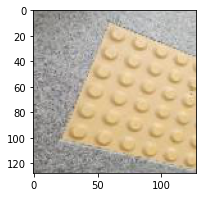

In [ ]:
# check
plt.figure(figsize=(3, 3))
plt.imshow(crop_zoomin[1])
plt.show()

In [ ]:
# crop으로 128,128로 데이터 사이즈 조정

r_destroyed = []

for img in r_destroyed_data:
  img = load_img(img)
  img = img_to_array(img).astype('float32')/255
  y = 48
  h = 128
  x = 48
  w = 128
  crop_img = img[y: y + h, x: x + w]
  r_destroyed.append(crop_img)

r_destroyed = np.array(r_destroyed)

In [ ]:
# train and test split
train_x, test_n = train_test_split(crop_zoomin, test_size=0.1, shuffle=True, random_state=42)

In [ ]:
print(train_x.shape)
print(test_n.shape)

(8796, 128, 128, 3)
(978, 128, 128, 3)


In [ ]:
# 테스트셋 생성(978개 정상 데이터, 29개 이상치)
test_x = np.vstack([test_n, r_destroyed])
test_x.shape

(1007, 128, 128, 3)

In [ ]:
# y_label 생성

y_n = np.zeros(978)
y_a = np.ones(29)

y_label = np.concatenate((y_n, y_a))
print(y_label.shape)

(1007,)


#3. 모델 생성

In [ ]:
model = Sequential()

model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Dense(2))

model.add(Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(3, (1, 1), activation="sigmoid", padding="same"))




model.compile(optimizer='adam', loss='mse', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

# 4. 모델 학습

In [18]:
# auto encoder : use model.fit(train_data, train_data, ....)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=50)
hist = model.fit(train_x, train_x, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
495/495 [==============================] - 33s 40ms/step - loss: 0.0118 - accuracy: 0.9433 - val_loss: 0.0062 - val_accuracy: 0.9450
Epoch 2/100
495/495 [==============================] - 19s 38ms/step - loss: 0.0055 - accuracy: 0.9201 - val_loss: 0.0052 - val_accuracy: 0.9094
Epoch 3/100
495/495 [==============================] - 19s 38ms/step - loss: 0.0051 - accuracy: 0.9082 - val_loss: 0.0055 - val_accuracy: 0.9211
Epoch 4/100
495/495 [==============================] - 19s 38ms/step - loss: 0.0049 - accuracy: 0.9122 - val_loss: 0.0049 - val_accuracy: 0.9127
Epoch 5/100
495/495 [==============================] - 19s 38ms/step - loss: 0.0048 - accuracy: 0.9139 - val_loss: 0.0048 - val_accuracy: 0.9241
Epoch 6/100
495/495 [==============================] - 19s 38ms/step - loss: 0.0047 - accuracy: 0.9208 - val_loss: 0.0047 - val_accuracy: 0.9272
Epoch 7/100
495/495 [==============================] - 19s 38ms/step - loss: 0.0047 - accuracy: 0.9239 - val_loss: 0.0051 - val_ac

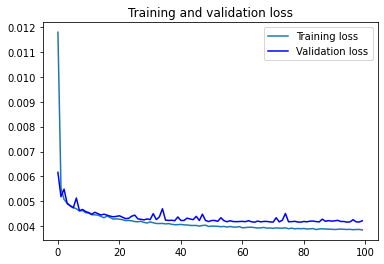

In [19]:
# plot loss history
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(loss))


plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#5. 모델 저장 및 불러오기

In [ ]:
model.save("ae_bottleneck_16_179epoch.h5")

In [ ]:
from tensorflow.keras.models import load_model
model= load_model("/gdrive/MyDrive/tmp/newdata/ae_bottleneck_16_179epoch.h5")

#6. 복원 실행

In [20]:
reconstructed = model.predict(train_x)

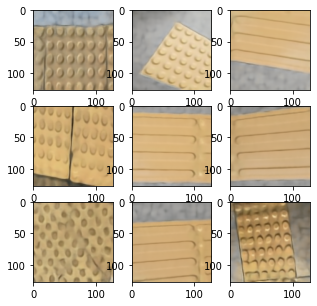

In [21]:
# 복원 확인하기

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(reconstructed[i].reshape((128,128,3)))

plt.show()

# 7. diff의 합계로 threshold 구하기

In [22]:
errors_sum = []

for (image, recon) in zip(train_x, reconstructed):
	# 두 이미지 데이터의 diff를 합산
  tmp = image - recon
  tmp = np.abs(tmp)
  tmp_2d = np.sum(tmp, axis = 2)
  tmp_1d = np.sum(tmp_2d, axis = 1)
  tmp_sum = np.sum(tmp_1d)
  errors_sum.append(tmp_sum)

In [23]:
errors_sum = np.array(errors_sum)
print(errors_sum.shape)

(8796,)


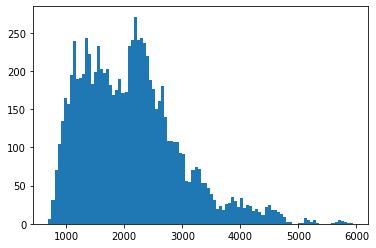

In [24]:
plt.hist(errors_sum, bins=100)
plt.show()

In [25]:
threshold_r = np.quantile(errors_sum, 0.995)
print(threshold_r)

4777.994335937496


#8. destroyed 데이터 복원 실행

In [26]:
reconstructed_r_destroyed = model.predict(r_destroyed)

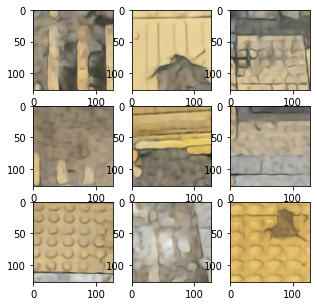

In [27]:
# 복원 확인하기

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(reconstructed_r_destroyed[i].reshape((128,128,3)))

plt.show()

In [28]:
errors_sum_r_destroyed = []

for (image, recon) in zip(r_destroyed, reconstructed_r_destroyed):
  # 두 이미지 데이터의 diff를 합산
  tmp = image - recon
  tmp = np.abs(tmp)
  tmp_2d = np.sum(tmp, axis = 2)
  tmp_1d = np.sum(tmp_2d, axis = 1)
  tmp_sum = np.sum(tmp_1d)
  print(tmp_sum)
  errors_sum_r_destroyed.append(tmp_sum)

6270.65
2026.7013
5179.7544
4622.785
5501.059
4797.451
3038.1262
7562.073
2205.1025
5251.377
2110.1592
2600.1855
2778.2976
1366.9182
4158.3716
4900.0474
3868.4658
3703.1216
6184.354
4810.566
3710.8708
1944.0164
5120.6973
3913.0786
3696.1074
3978.1165
3341.8
3132.6665
3545.3484


In [29]:
errors_sum_r_destroyed = np.array(errors_sum_r_destroyed)
print(errors_sum_r_destroyed.shape)

(29,)


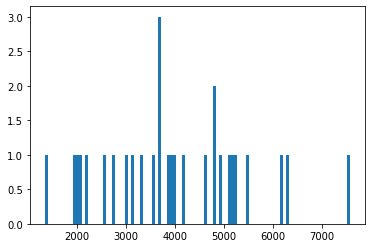

In [30]:
plt.hist(errors_sum_r_destroyed, bins=100)
plt.show()

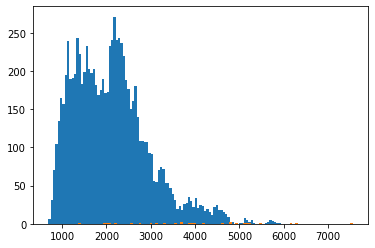

In [31]:
# train_x와 r_destroyed의 error값 분포
plt.hist(errors_sum, bins=100)
plt.hist(errors_sum_r_destroyed, bins=100)
plt.show()

In [32]:
# 이상치 탐지
anomaly_idxs_r = np.where(np.array(errors_sum_r_destroyed) >= threshold_r)[0]
print(len(anomaly_idxs_r))

10


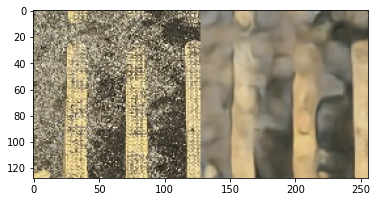

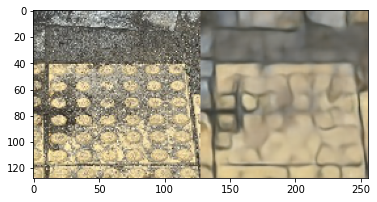

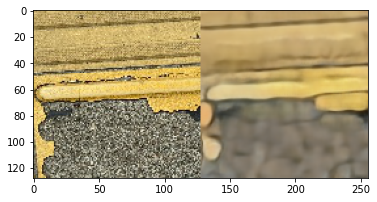

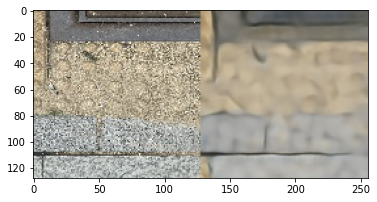

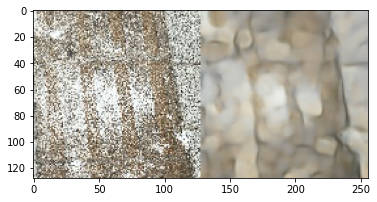

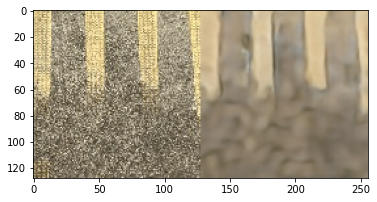

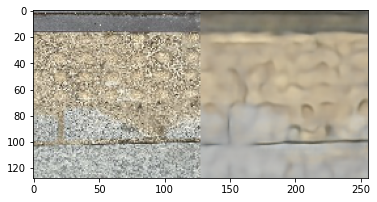

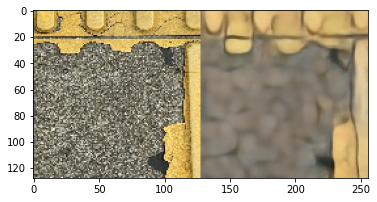

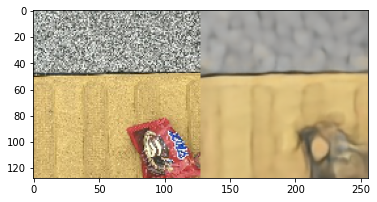

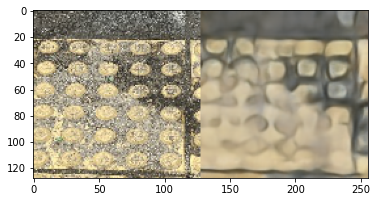

In [33]:
# 탐지된 이미지 확인
for i in anomaly_idxs_r:
  combined = np.hstack([r_destroyed[i], reconstructed_r_destroyed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

#9. test 데이터 복원 실행

In [34]:
reconstructed_test = model.predict(test_x)

In [36]:
# residual range로 anormaly detection
errors_sum_test = []

for (image, recon) in zip(test_x, reconstructed_test):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
  tmp = image - recon
  tmp = np.abs(tmp)
  tmp_2d = np.sum(tmp, axis = 2)
  tmp_1d = np.sum(tmp_2d, axis = 1)
  tmp_sum = np.sum(tmp_1d)
  #rge = np.max(tmp_2d) - np.min(tmp_2d) #rge == range
  errors_sum_test.append(tmp_sum)
  #errors_2d.append(rge)

In [37]:
errors_sum_test = np.array(errors_sum_test)
print(errors_sum_test.shape)

(1007,)


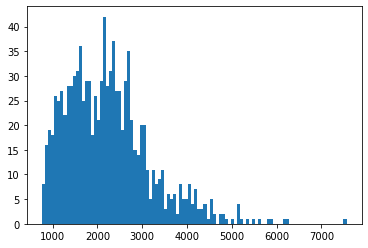

In [38]:
plt.hist(errors_sum_test, bins=100)
plt.show()

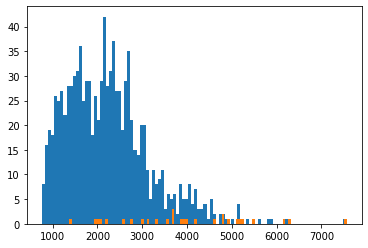

In [39]:
# test data와 destroyed 분포
plt.hist(errors_sum_test, bins=100)
plt.hist(errors_sum_r_destroyed, bins=100)
plt.show()

In [40]:
# 이상치 탐지
anomaly_idxs_r = np.where(np.array(errors_sum_test) >= threshold_r)[0]
print(len(anomaly_idxs_r))

17


In [41]:
# 탐지된 이미지 확인
for i in anomaly_idxs_r:
  combined = np.hstack([test_x[i], reconstructed_test[i]])
  plt.imshow(combined.squeeze())
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

정상 이미지: 4/978  
비정상 이미지: 7/29

#10. recall precision curve

In [42]:
error_df = pd.DataFrame({'Reconstruction_error': errors_sum_test, 
                         'True_class':list(y_label)})

In [43]:
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

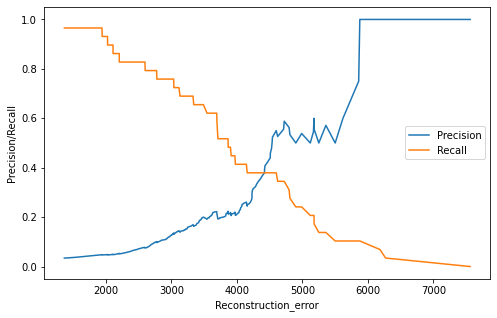

In [44]:
# recall precison curve 그리기
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Reconstruction_error'); plt.ylabel('Precision/Recall')

plt.legend()
plt.show()

In [45]:
# 최적의 threshold 구하기
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.3793103448275862 , recall:  0.3793103448275862
threshold:  4423.173


In [46]:
# threshold_fixed일때 test_x의 이상치 탐지
anomaly_idxs_r = np.where(np.array(errors_sum_test) >= threshold_fixed)[0]
print(len(anomaly_idxs_r))

29


In [47]:
# threshold_fixed일때 r_destroyed의 이상치 탐지
anomaly_idxs_r = np.where(np.array(errors_sum_r_destroyed) >= threshold_fixed)[0]
print(len(anomaly_idxs_r))

11


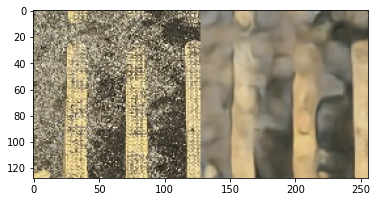

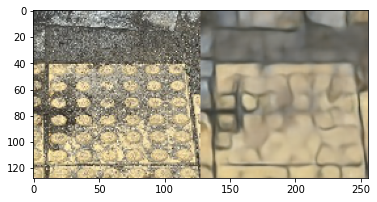

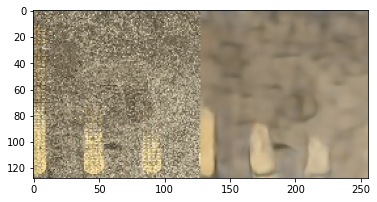

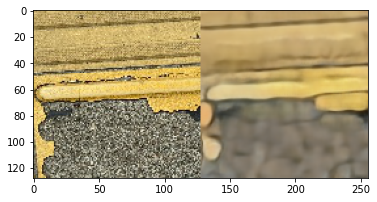

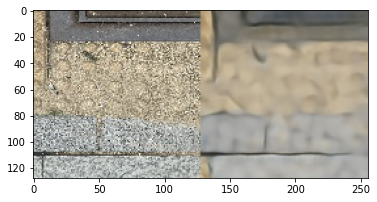

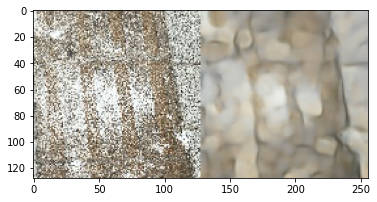

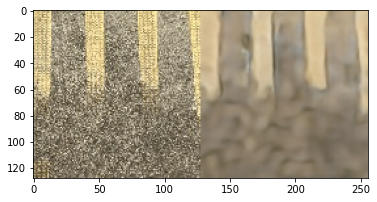

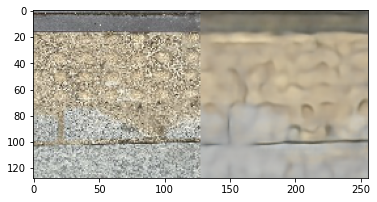

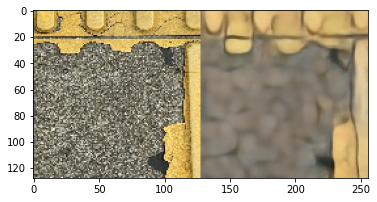

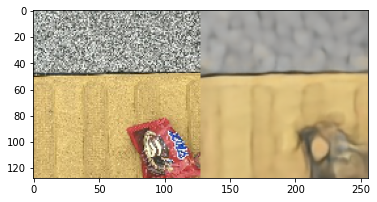

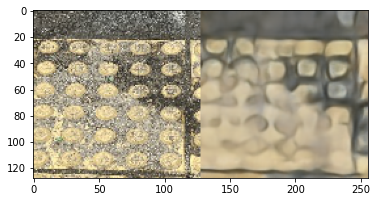

In [48]:
# r_destroyed의 이상치 이미지 출력
for i in anomaly_idxs_r:
  combined = np.hstack([r_destroyed[i], reconstructed_r_destroyed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

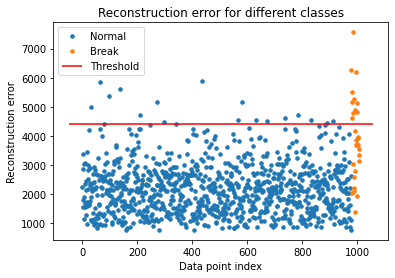

In [49]:
# reconstruction error 그래프 그리기
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

#11. confusion matrix로 표현

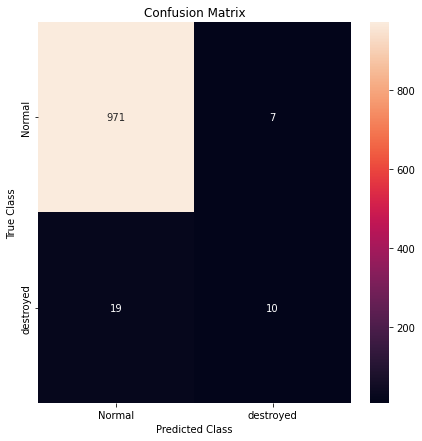

In [50]:
# threshold를 기준으로 했을때 confusion matrix
LABELS = ['Normal', 'destroyed']

pred_y = [1 if e > threshold_r else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

#12. ROC Curve & AUC

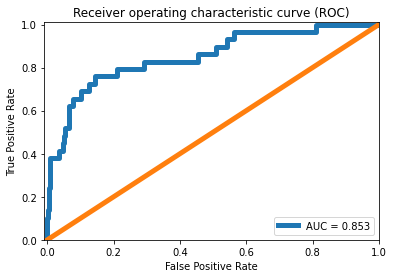

In [51]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)


plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

# tflite로 변환해서 저장

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("ae_bottleneck_16_179epoch.tflite", "wb").write(tflite_model)

3091256

In [ ]:
import os

def findfile(name, path):
    for dirpath, dirname, filename in os.walk(path):
        if name in filename:
            return os.path.join(dirpath, name)
filepath = findfile("ae_bottleneck_16_179epoch.tflite", "/")
print(filepath)

/content/ae_bottleneck_16_179epoch.tflite
